In [1]:
import glob                # 用于查询符合特定规则的文件路径名
import os                  # 处理文件和目录
import cv2                 # 用于图像处理
import  tensorflow as tf
from tensorflow.keras import layers, optimizers, datasets, Sequential  #从tensorflow.keras模块下导入layers，optimizers, datasets, Sequential等方法
import numpy as np                #导入numpy数据库
import matplotlib.pyplot as plt   #导入matplotlib.pyplot模块，主要用于展示图像
from sklearn.model_selection import train_test_split   #从sklearn.model_selection模块导入train_test_split方法,用于拆分数据集

In [2]:
path = '../flower_photos/'   # 数据集的相对地址，改为你自己的，建议将数据集放入代码文件夹下
# print(os.listdir(path))
# TODO 对图片进行缩放，统一处理为大小为w*h的图像，具体参数需自己定
w = 100      #设置图片宽度为10
h = 100      #设置图片高度为10
c = 3        #设置图片通道为3

In [3]:
def read_img(path):                                                    # 定义函数read_img，用于读取图像数据，并且对图像进行resize格式统一处理
    cate=[path+x for x in os.listdir(path) if os.path.isdir(path+x)]  # 创建层级列表cate，用于对数据存放目录下面的数据文件夹进行遍历，os.path.isdir用于判断文件是否是目录，然后对是目录的文件(os.listdir(path))进行遍历
    # print(cate)
    imgs=[]                                                            # 创建保存图像的空列表
    labels=[]                                                          # 创建用于保存图像标签的空列表
    for idx,folder in enumerate(cate):                                # enumerate函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和下标,一般用在for循环当中
        for im in glob.glob(folder+'/*.jpg'):                         # 利用glob.glob函数搜索每个层级文件下面符合特定格式“/*.jpg”的图片，并进行遍历
            #print('reading the images:%s'%(im))                      # 遍历图像的同时，打印每张图片的“路径+名称”信息
            img=cv2.imread(im)                                        # 利用cv2.imread函数读取每一张被遍历的图像并将其赋值给img
            img=cv2.resize(img,(w,h))                                 # 利用cv2.resize函数对每张img图像进行大小缩放，统一处理为大小为w*h的图像
            imgs.append(img)                                          # 将每张经过处理的图像数据保存在之前创建的imgs空列表当中
            labels.append(idx)                                        # 将每张经过处理的图像的标签数据保存在之前创建的labels列表当中
    return np.asarray(imgs,np.float32),np.asarray(labels,np.int32)   # 利用np.asarray函数对生成的imgs和labels列表数据进行转化，之后转化成数组数据（imgs转成浮点数型，labels转成整数型）

In [4]:
data,label=read_img(path)                                              # 将read_img函数处理之后的数据定义为样本数据data和标签数据label
# print("shape of data:",data.shape)                                     # 查看样本数据的大小 
# print("shape of label:",label.shape)                                   # 查看标签数据的大小 

In [5]:
seed = 109             # 设置随机数种子，即seed值
np.random.seed(seed)   # 保证生成的随机数具有可预测性,即相同的种子（seed值）所产生的随机数是相同的

(x_train, x_val, y_train, y_val) = train_test_split(data, label, test_size=0.20, random_state=seed) #拆分数据集
x_train = x_train / 255  #训练集图片标准化
x_val = x_val / 255      #测试集图片标准化

flower_dict = {0:'bee',1:'blackberry',2:'blanket',3:'bougainvillea',4:'bromelia',5:'foxglove'} #创建图像标签列表

In [6]:
# Todo 根据设计好的模型结构自行实现模型
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  # tf.keras.layers.RandomContrast(0.5, 1.5),
  # tf.keras.layers.RandomBrightness(0.2),
  # tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
])


model = tf.keras.Sequential([
  # data_augmentation,
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=(w, h, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])

In [7]:
# Todo 可调整超参数lr，可修改优化器类型
opt = optimizers.Adam(learning_rate=0.001)   #使用Adam优化器，优化模型参数。lr(learning rate, 学习率)

# Todo 可选择其他损失函数
#编译模型以供训练。使用多分类损失函数'sparse_categorical_crossentropy'，使用metrics=['accuracy']即评估模型在训练和测试时的性能的指标，使用的准确率。
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Todo 可调整超参数
#训练模型，决定训练集和验证集，batch size：进行梯度下降训练模型时每个batch包含的样本数。
#verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
model_name = 'model_ex-{epoch:03d}_acc-{val_accuracy:03f}.h5'
import time


trained_model_dir=f'C:\\Users\zzzgry\Desktop\midspore_lab2\model\\tensorflow/checkpoint/{time.localtime()}'
os.mkdir(trained_model_dir)
model_path = os.path.join(trained_model_dir, model_name)


checkpoint = tf.keras.callbacks.ModelCheckpoint(
             filepath=model_path,
             monitor='val_accuracy',
             verbose=1,
             save_weights_only=False,
             save_best_only=True,
             mode='max',
             period=1)


patience = 100
earlystop = tf.keras.callbacks.EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=patience)


epochs = 100
model.fit(x_train, y_train, 
          epochs=epochs, 
          shuffle=True,
          callbacks=[checkpoint], 
          validation_data=(x_val, y_val), 
          batch_size=32, 
          verbose=2)
#输出模型的结构和参数量,如果没有定义好模型或者模型参数有问题，运行会出错
model.summary()

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.39189, saving model to C:\Users\zzzgry\Desktop\midspore_lab2\model\tensorflow/checkpoint/time.struct_time(tm_year=2022, tm_mon=4, tm_mday=24, tm_hour=17, tm_min=7, tm_sec=7, tm_wday=6, tm_yday=114, tm_isdst=0)\model_ex-001_acc-0.391892.h5
19/19 - 3s - loss: 1.6779 - accuracy: 0.3226 - val_loss: 1.4696 - val_accuracy: 0.3919 - 3s/epoch - 133ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.39189 to 0.45270, saving model to C:\Users\zzzgry\Desktop\midspore_lab2\model\tensorflow/checkpoint/time.struct_time(tm_year=2022, tm_mon=4, tm_mday=24, tm_hour=17, tm_min=7, tm_sec=7, tm_wday=6, tm_yday=114, tm_isdst=0)\model_ex-002_acc-0.452703.h5
19/19 - 2s - loss: 1.4278 - accuracy: 0.4088 - val_loss: 1.3786 - val_accuracy: 0.4527 - 2s/epoch - 89ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.45270 to 0.49324, saving model to C:\Users\zzzgry\Desktop\midspore_lab2\model\tensorflow/checkpoint/time.struct_time(tm_year=2022

In [9]:
import time

model_name = f"w{w}_h{h}_epoch{epochs}_patience{patience}_time{time.localtime()}.h5"
model_path = "C:\\Users\\zzzgry\\Desktop\\midspore_lab2\\model\\tensorflow\\" + model_name

model.save(model_path)
# model_path

In [10]:
# model = tf.keras.models.load_model('./the_save_model.h5')
prediction = np.argmax(model.predict(x_val), axis=1)

correct = [1 if y_val[idx]==pred_label else 0 for idx, pred_label in enumerate(prediction)]
print(sum(correct) / len(correct))

0.8378378378378378


In [11]:
path_test = '../TestImages/' # 测试图像的地址 （改为自己的）

In [12]:
imgs=[]                                                 # 创建保存图像的空列表                                                    
for im in glob.glob(path_test+'/*.jpg'):               # 利用glob.glob函数搜索每个层级文件下面符合特定格式“/*.jpg”进行遍历
    #print('reading the images:%s'%(im))                # 遍历图像的同时，打印每张图片的“路径+名称”信息
    img=cv2.imread(im)                                  # 利用io.imread函数读取每一张被遍历的图像并将其赋值给img
    img=cv2.resize(img,(w,h))                           # 利用cv2.resize函数对每张img图像进行大小缩放，统一处理为大小为w*h的图像
    imgs.append(img)                                    # 将每张经过处理的图像数据保存在之前创建的imgs空列表当中
imgs = np.asarray(imgs,np.float32)    # 利用np.asarray()函数对imgs进行数据转换
print("shape of data:",imgs.shape)

shape of data: (6, 100, 100, 3)


1.0
第 1 朵花预测:bee


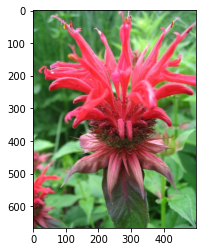

第 2 朵花预测:blackberry


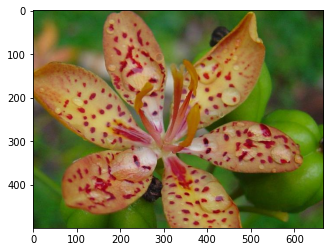

第 3 朵花预测:blanket


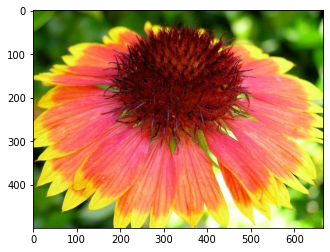

第 4 朵花预测:bougainvillea


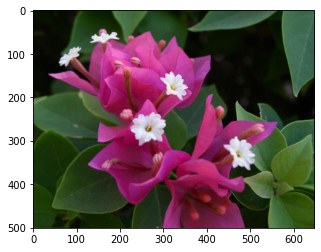

第 5 朵花预测:bromelia


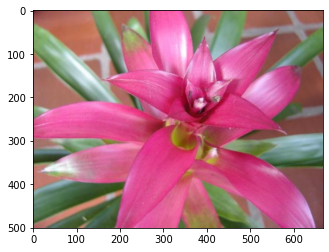

第 6 朵花预测:foxglove


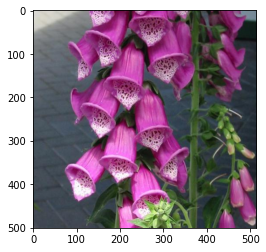

In [13]:
# prediction = model.predict_classes(imgs)      #将图像导入模型进行预测
# model = tf.keras.models.load_model('./model/checkpoint/time.struct_time(tm_year=2022, tm_mon=4, tm_mday=20, tm_hour=16, tm_min=52, tm_sec=23, tm_wday=2, tm_yday=110, tm_isdst=0)/model_ex-069_acc-0.884615.h5')
prediction = np.argmax(model.predict(imgs), axis=1)

correct = [1 if idx==pred_label else 0 for idx, pred_label in enumerate(prediction)]
print(sum(correct) / len(correct))

#绘制预测图像
for i in range(np.size(prediction)):
    #打印每张图像的预测结果
    print("第",i+1,"朵花预测:"+flower_dict[prediction[i]])  # flower_dict:定义的标签列表，prediction[i]：预测的结果
    img = plt.imread(path_test+"test"+str(i+1)+".jpg")      # 使用imread()函数读入对应的图片
    #img = plt.imread(path_test)
    plt.imshow(img)              #展示图片
    plt.show()                   #显示图片